In [ ]:
import numpy as np
import pandas as pd
import os
import lightgbm as lgb
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
import seaborn as sns
import random

from sklearn import svm
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import StratifiedKFold
from sklearn.model_selection import StratifiedShuffleSplit
from sklearn.model_selection import RandomizedSearchCV
from sklearn.model_selection import GridSearchCV
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.metrics import precision_recall_curve
from sklearn.metrics import classification_report
from sklearn.metrics import roc_auc_score
from sklearn.metrics import roc_curve
from sklearn.metrics import f1_score
from sklearn.metrics import matthews_corrcoef
from sklearn.metrics import confusion_matrix
from sklearn.metrics import make_scorer


from google.colab import drive
from datetime import datetime

In [ ]:
drive.mount('/content/drive')
root_path = 'drive/My Drive/KU/Robin_lab_project' 
os.chdir(root_path)

Mounted at /content/drive


In [ ]:
# Set details for saving the plots
DIRECTORY = "Plots/rank_negFiltered_atleast2max_negRatio_0.5_v2/"
FILENAME = "rank_negFiltered_atleast2max_negRatio_0.5_v2"

# Data exploration

In [ ]:
# Load data 
profiles_all = pd.read_csv(f"Data/ML_input/profiles_{FILENAME}.csv")
metadata_all = pd.read_csv(f"Data/ML_input/metadata_{FILENAME}.csv")

X = profiles_all.drop("label", axis=1)
X = StandardScaler().fit_transform(X)
y = profiles_all["label"]

print(X.shape)
print(y.shape)

(90783, 1002)
(90783,)


### PCA


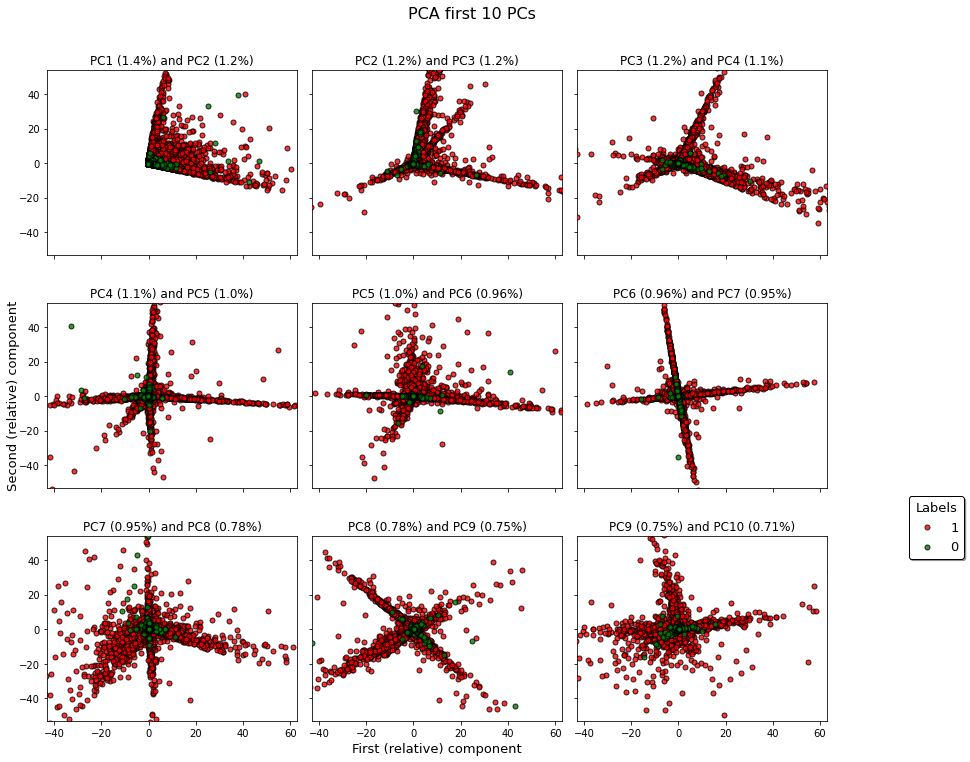

In [ ]:
#  PCA plot
def multi_plot_pca(x, y, 
                   nrows=2, xlim=(-23,43), ylim=(-23,23),
                   figsize=(12,7), top=0.89,
                   title="", save=False, filename="pca_multiplot"):
  # Perform PCA and MDS
  n_pcs = nrows*3+1
  pca = PCA(n_components=n_pcs)
  pcs = pca.fit_transform(x)
  var = pca.explained_variance_ratio_ * 100
  tmp_df = pd.concat([pd.DataFrame(pcs), y], axis = 1)
  targets = [1,0]
  colors = ["r","g"]
  # Plot fig and axes
  fig, axes = plt.subplots(nrows, 3, figsize = figsize, sharex=True, sharey=True)
  fig.add_subplot(111, frameon=False)
  for target, color in zip(targets,colors):
    i_keep = tmp_df['label'] == target
    for i ,ax in enumerate(axes.flatten()):
      ax.scatter(tmp_df.loc[i_keep,i], tmp_df.loc[i_keep,i+1], zorder=3, 
                      ec="black", c=color, s=25, alpha = 0.8, label = target) 
      ax.set_title(f"PC{i+1} ({var[i]:.2}%) and PC{i+2} ({var[i+1]:.2}%)")
      ax.set_xlim(xlim)
      ax.set_ylim(ylim)
  # Details
  legend = ax.legend(title="Labels", fontsize=13, title_fontsize=13,
                     frameon = 1, shadow = True, bbox_to_anchor=(1.3, 1.25))
  frame = legend.get_frame()
  frame.set_facecolor('white')
  frame.set_edgecolor('black')
  plt.tick_params(labelcolor='none', top=False, bottom=False, left=False, right=False)
  fig.suptitle(f"PCA first {n_pcs} PCs{title}", fontsize=16)
  plt.xlabel("First (relative) component", fontsize=13)
  plt.ylabel("Second (relative) component", fontsize=13)
  fig.tight_layout()
  fig.subplots_adjust(top=top)
  if save == True:
      plt.savefig(f"{DIRECTORY}{filename}_{FILENAME}.png", dpi = 300)
  plt.show()

multi_plot_pca(X, y, nrows=3, xlim=(-43,63), ylim=(-53,54),
               figsize=(14,11), top=0.9, save=True)     

### Correlation

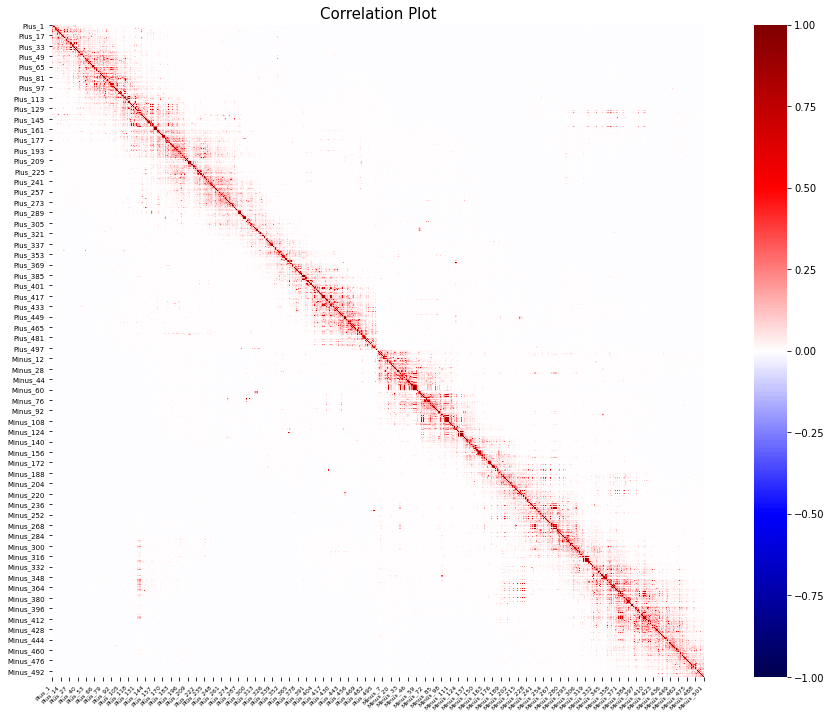

In [ ]:
# Correlation
X = pd.DataFrame(X, columns = list(profiles_all.drop("label", axis=1).columns))
correlation = X.corr(method='pearson')

# Plot
fig, ax = plt.subplots(figsize=(18, 12))
sns.heatmap(correlation, mask = np.zeros_like(correlation, dtype = np.bool), cmap = "seismic",
            square=True, ax=ax, vmin=-1, vmax=1)
plt.title("Correlation Plot", fontsize=15)
plt.xticks(rotation=45, ha='right', fontsize=6)
plt.yticks(fontsize=7)
plt.savefig(f"{DIRECTORY}correlation_plot_{FILENAME}.png", dpi = 300)
plt.show()

# Models development

### Split train and test by chromosomes number

In [ ]:
# Load data divded by chr number
profiles_train = pd.read_csv(f"Data/ML_input/profiles_{FILENAME}_train.csv")
profiles_test = pd.read_csv(f"Data/ML_input/profiles_{FILENAME}_test.csv")
metadata_train = pd.read_csv(f"Data/ML_input/metadata_{FILENAME}_train.csv")
metadata_test = pd.read_csv(f"Data/ML_input/metadata_{FILENAME}_test.csv")

# Divide predictor and target
X_TRAIN = profiles_train.drop("label", axis = 1)
y_TRAIN = profiles_train["label"]
X_TEST = profiles_test.drop("label", axis = 1)
y_TEST = profiles_test["label"]

# # Normalization
# scaler = StandardScaler()
# X_TRAIN = scaler.fit_transform(X_TRAIN)
# X_TEST = scaler.transform(X_TEST)

print(X_TRAIN.shape)
print(y_TRAIN.shape)
print(X_TEST.shape)
print(y_TEST.shape)

(74683, 1002)
(74683,)
(16100, 1002)
(16100,)


Some useful functions

In [ ]:
def get_accuracy(ypred, y):
  return sum(ypred == y) / len(y)

def get_rmse(yprob, y):
  return np.sqrt(np.mean((yprob-y)**2))

def print_eval(ytrain, ytrain_pred, ytrain_prob, ytest, ytest_pred, ytest_prob, name):
  print(f"{name} train accuracy: {get_accuracy(ytrain_pred, ytrain):.4}")
  print(f"{name} train F1-score: {f1_score(ytrain, ytrain_pred):.4}")  
  print(f"{name} train MCC: {matthews_corrcoef(ytrain, ytrain_pred):.4}")
  print(f"{name} test accuracy: {get_accuracy(ytest_pred, ytest):.4}")
  print(f"{name} test F1-score: {f1_score(ytest, ytest_pred):.4}")
  print(f"{name} test MCC: {matthews_corrcoef(ytest, ytest_pred):.4}")

def print_output_eval(train_output, val_output, name):
  train_acc = get_accuracy(train_output["ypred"].values, train_output["ytrue"].values)
  val_acc = get_accuracy(val_output["ypred"].values, val_output["ytrue"].values)
  train_f1 = f1_score(train_output["ytrue"].values, train_output["ypred"].values)
  val_f1 = f1_score(val_output["ytrue"].values, val_output["ypred"].values)
  train_mcc = matthews_corrcoef(train_output["ytrue"].values, train_output["ypred"].values)
  val_mcc = matthews_corrcoef(val_output["ytrue"].values, val_output["ypred"].values)
  print(f"\n>> {name} final report")
  print(f"Train CV accuracy: {train_acc:.4}")
  print(f"Train CV F1-score: {train_f1:.4}")
  print(f"Train MCC: {train_mcc:.4}")
  print(f"Valid CV accuracy: {val_acc:.4}")
  print(f"Valid CV F1-score: {val_f1:.4}")
  print(f"Valid CV MCC: {val_mcc:.4}")


Randomly split TRAIN into train and validation keeping labels proportion (used as faster validation in alternative to CV)

In [ ]:
# Split training set into train and validation
sss = StratifiedShuffleSplit(n_splits=1, test_size=0.2, random_state=20)
sss.split(X_TRAIN, y_TRAIN)

for itrain, ival in sss.split(X_TRAIN, y_TRAIN):
  X_train, X_val = X_TRAIN.iloc[itrain], X_TRAIN.iloc[ival]
  y_train, y_val = y_TRAIN[itrain], y_TRAIN[ival]

# Normalization
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_val = scaler.transform(X_val)

print(X_train.shape)
print(y_train.shape)
print(X_val.shape)
print(y_val.shape)

(59746, 1002)
(59746,)
(14937, 1002)
(14937,)


Subset the data for fast testing

In [ ]:
# # Use reduced size for fast testing
# metadata_train = metadata_train[:3000]
# X_TRAIN, y_TRAIN = X_TRAIN[:3000], y_TRAIN[:3000]
# X_train, y_train = X_train[:2000], y_train[:2000]
# X_val, y_val = X_val[:1000], y_val[:1000] 

# print(metadata_train.shape)
# print(X_TRAIN.shape, y_TRAIN.shape)
# print(X_train.shape, y_train.shape)
# print(X_val.shape, y_val.shape)

In [ ]:
# # Further reduce the size
# metadata_train = metadata_train[:300]
# X_TRAIN, y_TRAIN = X_TRAIN[:300], y_TRAIN[:300]
# X_train, y_train = X_train[:200], y_train[:200]
# X_val, y_val = X_val[:100], y_val[:100] 

# print(metadata_train.shape)
# print(X_TRAIN.shape, y_TRAIN.shape)
# print(X_train.shape, y_train.shape)
# print(X_val.shape, y_val.shape)

## Random forest

### Hyperparameter tuning

In [ ]:
# Custom CV split by chromosomes
def cv_split_by_chr(metadata, n_val_chr=6):
  chr_list = np.unique(metadata.chr)
  random.shuffle(chr_list)
  k = len(chr_list) // n_val_chr
  val_chr_folds = np.array_split(chr_list, k)
  print("Validation chromosomes:")
  [print(list(x)) for x in val_chr_folds]
  # Generate a list of tuple where each tuple contain two list of indexes (train and val)
  list_fold_index = []
  for val_chr in val_chr_folds:
    ival = metadata.chr.isin(val_chr)
    list_fold_index.append((list(np.where(~ival)[0]), list(np.where(ival)[0])))
  return list_fold_index

# Hyperparameters random or grid search
def par_search(model, param_grid,
               xtrain, ytrain, metadata, 
               search="random", n_iter=24, n_val_chr=6, verbose=10):
  if search == "random":
    print(f"Hyperparameters search = {search}\n")
    model_search = RandomizedSearchCV(estimator = model, param_distributions = param_grid, n_iter = n_iter, 
                                      return_train_score = True, cv = cv_split_by_chr(metadata, n_val_chr=n_val_chr), 
                                      scoring = make_scorer(f1_score, average = "micro"), verbose=verbose)
  elif search == "grid":
    print(f"Hyperparameters search = {search}\n")
    model_search = GridSearchCV(estimator = model, param_grid = param_grid, return_train_score = True,
                                cv = cv_split_by_chr(metadata, n_val_chr=n_val_chr), 
                                scoring = make_scorer(f1_score, average = "micro"), verbose=verbose)
  try:
    print("\nParameter grid:")
    display(param_grid)
    print("")
    model_search.fit(xtrain, ytrain)
    return model_search
  except:
    print("Search argument must be \"random\" or \"grid\"")

Comment out the following for parameter tuning

In [ ]:
# # Perform search
# bootstrap = [True, False]
# criterion = ['gini']
# n_estimators = [10, 20, 100, 500, 1000]
# max_features = ["auto"]
# max_depth = [104, None]
# min_samples_split = [2, 5, 10, 0.1]
# min_samples_leaf = [1, 2, 4, 0.1]
# max_leaf_nodes = [None]

# param_grid = { 
#     "bootstrap": bootstrap,
#     "criterion" : criterion,
#     "n_estimators": n_estimators,
#     "max_features": max_features,
#     "max_depth" : max_depth,
#     "min_samples_split": min_samples_split,
#     "min_samples_leaf": min_samples_leaf,
#     "max_leaf_nodes": max_leaf_nodes
# }

# rf_clf = RandomForestClassifier(n_jobs=-1)
# rf_search_output = par_search(rf_clf, param_grid,
#                               X_TRAIN, y_TRAIN, metadata_train, 
#                               search="grid", n_val_chr=6, verbose=5)

In [ ]:
# def get_search_combination(search_output):
#   result_search = pd.DataFrame(search_output.cv_results_)
#   drop_col1 = ['std_fit_time', 'mean_score_time', 'std_score_time', 'params', 'std_test_score', 'std_train_score']
#   drop_col2 = result_search.columns[result_search.columns.str.startswith('split')]
#   drop_col = drop_col1 + list(drop_col2)
#   result_search = result_search.drop(drop_col, axis = 1).sort_values("rank_test_score")
#   return result_search

# rf_par_combination = get_search_combination(rf_search_output)
# display(rf_par_combination.head(20))

# rf_par_combination.to_csv(f"{DIRECTORY}rf_opt_parameters_{FILENAME}.csv", index=False)

In [ ]:
# # Assign optimal parameters
# rf_opt_par = rf_par_combination.iloc[:,rf_par_combination.columns.str.startswith('param')].head(1)
# display(rf_opt_par)

# [rf_opt_bootstrap, rf_opt_criterion, rf_opt_max_depth, rf_opt_max_features, 
# rf_opt_max_leaf_nodes, rf_opt_min_samples_leaf, rf_opt_min_samples_split, 
# rf_opt_n_estimators] = list(rf_opt_par.values[0])

### Validation

In [ ]:
def rf_train_pred(xtrain, ytrain, xtest, ytest, 
                  n_estimators=100, bootstrap=True, criterion="gini", 
                  max_depth=None, max_features="auto", max_leaf_nodes=None,
                  min_samples_leaf=1, min_samples_split=2, class_weigth=None,
                  name="RF"):
  start_time = datetime.now()
  # Train
  model = RandomForestClassifier(n_estimators=n_estimators, bootstrap=bootstrap, 
                                 criterion=criterion, max_depth=max_depth, 
                                 max_features=max_features, class_weight=class_weigth)
  model.fit(xtrain, ytrain)
  # Predict
  ytrain_pred = model.predict(xtrain)
  ytrain_prob = model.predict_proba(xtrain)[:,1]
  ytest_pred = model.predict(xtest)
  ytest_prob = model.predict_proba(xtest)[:,1]
  # Evaluate
  print_eval(ytrain, ytrain_pred, ytrain_prob, ytest, ytest_pred, ytest_prob, name)
  # Report time 
  print(f"Duration: {datetime.now() - start_time}")
  return model, ytrain_prob, ytrain_pred, ytest_prob, ytest_pred,

#rf_model, rf_train_yprob, rf_train_ypred, rf_val_yprob, rf_val_ypred = rf_train_pred(X_train, y_train, X_val, y_val)   

In [ ]:
# Random forest CV
def rf_cv(xtrain, ytrain, metadata, n_val_chr=3, 
          n_estimators=100, bootstrap="True", criterion="gini", 
          max_depth=None, max_features="auto", max_leaf_nodes=None,
          min_samples_leaf=1, min_samples_split=2, class_weigth=None,
          name="RF"):
  start_time = datetime.now()
  print(f"Performing {name} CV")
  # Initialize arrays to store predictions, true values and feat importance
  train_yprob_vec, train_ypred_vec, train_ytrue_vec = np.array([]), np.array([]), np.array([])
  val_yprob_vec, val_ypred_vec, val_ytrue_vec = np.array([]), np.array([]), np.array([])
  importance = pd.DataFrame()
  importance["feature"] = list(xtrain.columns)
  # CV by chromosomes
  chr_list = np.unique(metadata.chr)
  random.shuffle(chr_list)
  k = len(chr_list) // n_val_chr
  val_chr_folds = np.array_split(chr_list, k)
  for i, val_chr in enumerate(val_chr_folds):
    print(f"\n> Starting CV iteration {i+1}, valid chrs = {val_chr}")
    ival = metadata.chr.isin(val_chr)
    X_train, X_val = X_TRAIN[~ival], X_TRAIN[ival]
    y_train, y_val = y_TRAIN[~ival], y_TRAIN[ival]
    # Normalization
    # scaler = StandardScaler()
    # X_train = scaler.fit_transform(X_train)
    # X_val = scaler.transform(X_val)
    # Train and predict
    [model, train_yprob, train_ypred, 
     val_yprob, val_ypred] = rf_train_pred(X_train, y_train, X_val, y_val, 
                                           n_estimators=n_estimators, bootstrap=bootstrap, 
                                           criterion=criterion, max_depth=max_depth, 
                                           max_features=max_features, max_leaf_nodes=max_leaf_nodes,
                                           min_samples_leaf=min_samples_leaf, min_samples_split=min_samples_split,
                                           class_weigth=class_weigth)
    importance[f"iteration_{i+1}"] = model.feature_importances_
    # Store prediction on training data
    train_yprob_vec = np.concatenate((train_yprob_vec, train_yprob))
    train_ypred_vec = np.concatenate((train_ypred_vec, train_ypred))
    train_ytrue_vec = np.concatenate((train_ytrue_vec, y_train))
    # Store prediction on validation data
    val_yprob_vec = np.concatenate((val_yprob_vec, val_yprob))
    val_ypred_vec = np.concatenate((val_ypred_vec, val_ypred))
    val_ytrue_vec = np.concatenate((val_ytrue_vec, y_val))
  # Stack training and validation predictions into two panda df
  train_output = pd.DataFrame({"yprob": train_yprob_vec, "ypred": train_ypred_vec, "ytrue": train_ytrue_vec})
  val_output = pd.DataFrame({"yprob": val_yprob_vec, "ypred": val_ypred_vec, "ytrue": val_ytrue_vec})
  importance["average"] = np.mean(importance, 1)
  # Evaluate
  print_output_eval(train_output, val_output, name)
  # Report time 
  print(f"Duration: {datetime.now() - start_time}")
  return train_output, val_output, importance

rf_train_output, rf_val_output, rf_importance = rf_cv(X_TRAIN, y_TRAIN, metadata_train)
rf_bal_train_output, rf_bal_val_output, rf_bal_importance = rf_cv(X_TRAIN, y_TRAIN, metadata_train, 
                                                                  class_weigth="balanced")
rf_balsub_train_output, rf_balsub_val_output, rf_balsub_importance = rf_cv(X_TRAIN, y_TRAIN, metadata_train, 
                                                                                   class_weigth="balanced_subsample")

Performing RF CV

> Starting CV iteration 1, valid chrs = ['chrX' 'chr17' 'chr18']
RF train accuracy: 0.9513
RF train F1-score: 0.963
RF train MCC: 0.8934
RF test accuracy: 0.7468
RF test F1-score: 0.8179
RF test MCC: 0.4079
Duration: 0:05:04.203306

> Starting CV iteration 2, valid chrs = ['chr9' 'chrY' 'chr11']
RF train accuracy: 0.9519
RF train F1-score: 0.9635
RF train MCC: 0.8946
RF test accuracy: 0.7273
RF test F1-score: 0.8005
RF test MCC: 0.3739
Duration: 0:05:02.234864

> Starting CV iteration 3, valid chrs = ['chr15' 'chr21' 'chr1']
RF train accuracy: 0.9529
RF train F1-score: 0.9641
RF train MCC: 0.8969
RF test accuracy: 0.7365
RF test F1-score: 0.8106
RF test MCC: 0.3803
Duration: 0:04:42.658090

> Starting CV iteration 4, valid chrs = ['chr14' 'chr12' 'chr19']
RF train accuracy: 0.9501
RF train F1-score: 0.9619
RF train MCC: 0.8914
RF test accuracy: 0.7497
RF test F1-score: 0.8246
RF test MCC: 0.3955
Duration: 0:04:45.148546

> Starting CV iteration 5, valid chrs = ['chr13

Comment out the following for optimized paramters validation

In [ ]:
# rf_opt_train_output, rf_opt_val_output, rf_opt_importance = rf_cv(X_TRAIN, y_TRAIN, metadata_train, 
#                                                                   n_estimators=rf_opt_n_estimators, 
#                                                                   bootstrap=rf_opt_bootstrap, 
#                                                                   criterion=rf_opt_criterion, 
#                                                                   max_depth=rf_opt_max_depth, 
#                                                                   max_features=rf_opt_max_features,
#                                                                   max_leaf_nodes=rf_opt_max_leaf_nodes,
#                                                                   min_samples_leaf=rf_opt_min_samples_leaf,
#                                                                   min_samples_split=rf_opt_min_samples_split)

## LightGBM    

In [ ]:
def lgb_train_pred(xtrain, ytrain, xtest, ytest, par, name="LGBM"):
  start_time = datetime.now()
  # Train
  train_data = lgb.Dataset(xtrain , label = ytrain)
  valid_data = lgb.Dataset(xtest, label = ytest)
  model = lgb.train(par, train_data, valid_sets=[valid_data], verbose_eval=20) 
  # Predict
  ytrain_prob = model.predict(np.array(xtrain))
  ytrain_pred = np.round(ytrain_prob)
  ytest_prob = model.predict(np.array(xtest))
  ytest_pred = np.round(ytest_prob)
  # Evaluate
  print_eval(ytrain, ytrain_pred, ytrain_prob, ytest, ytest_pred, ytest_prob, name)
  # Report time 
  print(f"Duration: {datetime.now() - start_time}")
  return model, ytrain_prob, ytrain_pred, ytest_prob, ytest_pred

params = {"application" : "binary",
          "num_boost_round" : 400,
         # "metric" :"binary_logloss",
          "metric" :"binary_error",
          "force_row_wise" : True,
          "learning_rate" : 0.009,            
         # "sub_feature" : 0.8,
         # "sub_row" : 0.75,
         # "bagging_freq" : 1,
         # "lambda_l2" : 0.1,
         # 'verbosity': 1,
          'num_iterations' : 1500
         # 'num_leaves': 128,
         # "min_data_in_leaf": 100
}

#lgb_model, lgb_train_yprob, lgb_train_ypred, lgb_val_yprob, lgb_val_ypred = lgb_train_pred(X_train, y_train, X_val, y_val, params)

In [ ]:
# LGBM CV
def lgb_cv(xtrain, ytrain, metadata, par, n_val_chr=3, kfold=10, name="LGBM"):
  start_time = datetime.now()
  print(f"Performing {name} CV")
  # Initialize 1d df to store predictions and true values
  train_yprob_vec, train_ypred_vec, train_ytrue_vec = np.array([]), np.array([]), np.array([])
  val_yprob_vec, val_ypred_vec, val_ytrue_vec = np.array([]), np.array([]), np.array([])
  importance = pd.DataFrame()
  importance["feature"] = list(xtrain.columns)
  # CV by chromosomes
  chr_list = np.unique(metadata.chr)
  random.shuffle(chr_list)
  k = len(chr_list) // n_val_chr
  val_chr_folds = np.array_split(chr_list, k)
  for i, val_chr in enumerate(val_chr_folds):
    print(f"\n> Starting CV iteration {i+1}, valid chrs = {val_chr}")
    ival = metadata.chr.isin(val_chr)
    X_train, X_val = X_TRAIN[~ival], X_TRAIN[ival]
    y_train, y_val = y_TRAIN[~ival], y_TRAIN[ival]
    # Normalization
    scaler = StandardScaler()
    X_train = scaler.fit_transform(X_train)
    X_val = scaler.transform(X_val)
    # Train and predict
    model, train_yprob, train_ypred, val_yprob, val_ypred = lgb_train_pred(X_train, y_train, X_val, y_val, par=par)
    importance[f"iteration_{i+1}"] = model.feature_importance(importance_type='gain')
    # Store prediction on training data
    train_yprob_vec = np.concatenate((train_yprob_vec, train_yprob))
    train_ypred_vec = np.concatenate((train_ypred_vec, train_ypred))
    train_ytrue_vec = np.concatenate((train_ytrue_vec, y_train))
    # Store prediction on validation data
    val_yprob_vec = np.concatenate((val_yprob_vec, val_yprob))
    val_ypred_vec = np.concatenate((val_ypred_vec, val_ypred))
    val_ytrue_vec = np.concatenate((val_ytrue_vec, y_val))
  # Stack training and validation predictions into two panda df
  train_output = pd.DataFrame({"yprob": train_yprob_vec, "ypred": train_ypred_vec,"ytrue": train_ytrue_vec})
  val_output = pd.DataFrame({"yprob": val_yprob_vec, "ypred": val_ypred_vec,"ytrue": val_ytrue_vec})
  importance["average"] = np.mean(importance, 1)
  # Evaluate
  print_output_eval(train_output, val_output, name)
  # Report time 
  print(f"Duration: {datetime.now() - start_time}")
  return train_output, val_output, importance

lgb_train_output, lgb_val_output, lgb_importance = lgb_cv(X_TRAIN, y_TRAIN, metadata_train, params)

Performing LGBM CV

> Starting CV iteration 1, valid chrs = ['chr7' 'chr8' 'chr21']


/usr/local/lib/python3.6/dist-packages/lightgbm/engine.py:118: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))


[20]	valid_0's binary_error: 0.340552
[40]	valid_0's binary_error: 0.340552
[60]	valid_0's binary_error: 0.340552
[80]	valid_0's binary_error: 0.340552
[100]	valid_0's binary_error: 0.340552
[120]	valid_0's binary_error: 0.340552
[140]	valid_0's binary_error: 0.340552
[160]	valid_0's binary_error: 0.340552
[180]	valid_0's binary_error: 0.340552
[200]	valid_0's binary_error: 0.340552
[220]	valid_0's binary_error: 0.261295
[240]	valid_0's binary_error: 0.255579
[260]	valid_0's binary_error: 0.25305
[280]	valid_0's binary_error: 0.249203
[300]	valid_0's binary_error: 0.248873
[320]	valid_0's binary_error: 0.248214
[340]	valid_0's binary_error: 0.247994
[360]	valid_0's binary_error: 0.247774
[380]	valid_0's binary_error: 0.247334
[400]	valid_0's binary_error: 0.247884
[420]	valid_0's binary_error: 0.248214
[440]	valid_0's binary_error: 0.247224
[460]	valid_0's binary_error: 0.247554
[480]	valid_0's binary_error: 0.247444
[500]	valid_0's binary_error: 0.247224
[520]	valid_0's binary_error: 

/usr/local/lib/python3.6/dist-packages/lightgbm/engine.py:118: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))


[20]	valid_0's binary_error: 0.318375
[40]	valid_0's binary_error: 0.318375
[60]	valid_0's binary_error: 0.318375
[80]	valid_0's binary_error: 0.318375
[100]	valid_0's binary_error: 0.318375
[120]	valid_0's binary_error: 0.318375
[140]	valid_0's binary_error: 0.318375
[160]	valid_0's binary_error: 0.318375
[180]	valid_0's binary_error: 0.318375
[200]	valid_0's binary_error: 0.318375
[220]	valid_0's binary_error: 0.256643
[240]	valid_0's binary_error: 0.257847
[260]	valid_0's binary_error: 0.255599
[280]	valid_0's binary_error: 0.253512
[300]	valid_0's binary_error: 0.252147
[320]	valid_0's binary_error: 0.252468
[340]	valid_0's binary_error: 0.25303
[360]	valid_0's binary_error: 0.25295
[380]	valid_0's binary_error: 0.250863
[400]	valid_0's binary_error: 0.250943
[420]	valid_0's binary_error: 0.251987
[440]	valid_0's binary_error: 0.251585
[460]	valid_0's binary_error: 0.251987
[480]	valid_0's binary_error: 0.251104
[500]	valid_0's binary_error: 0.251184
[520]	valid_0's binary_error: 0

/usr/local/lib/python3.6/dist-packages/lightgbm/engine.py:118: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))


[20]	valid_0's binary_error: 0.325443
[40]	valid_0's binary_error: 0.325443
[60]	valid_0's binary_error: 0.325443
[80]	valid_0's binary_error: 0.325443
[100]	valid_0's binary_error: 0.325443
[120]	valid_0's binary_error: 0.325443
[140]	valid_0's binary_error: 0.325443
[160]	valid_0's binary_error: 0.325443
[180]	valid_0's binary_error: 0.325443
[200]	valid_0's binary_error: 0.325443
[220]	valid_0's binary_error: 0.255513
[240]	valid_0's binary_error: 0.252543
[260]	valid_0's binary_error: 0.252903
[280]	valid_0's binary_error: 0.254433
[300]	valid_0's binary_error: 0.255333
[320]	valid_0's binary_error: 0.256503
[340]	valid_0's binary_error: 0.257313
[360]	valid_0's binary_error: 0.257583
[380]	valid_0's binary_error: 0.257043
[400]	valid_0's binary_error: 0.256683
[420]	valid_0's binary_error: 0.256053
[440]	valid_0's binary_error: 0.256593
[460]	valid_0's binary_error: 0.256143
[480]	valid_0's binary_error: 0.256863
[500]	valid_0's binary_error: 0.257133
[520]	valid_0's binary_error:

/usr/local/lib/python3.6/dist-packages/lightgbm/engine.py:118: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))


[20]	valid_0's binary_error: 0.329545
[40]	valid_0's binary_error: 0.329545
[60]	valid_0's binary_error: 0.329545
[80]	valid_0's binary_error: 0.329545
[100]	valid_0's binary_error: 0.329545
[120]	valid_0's binary_error: 0.329545
[140]	valid_0's binary_error: 0.329545
[160]	valid_0's binary_error: 0.329545
[180]	valid_0's binary_error: 0.329545
[200]	valid_0's binary_error: 0.329545
[220]	valid_0's binary_error: 0.252106
[240]	valid_0's binary_error: 0.246382
[260]	valid_0's binary_error: 0.245237
[280]	valid_0's binary_error: 0.246545
[300]	valid_0's binary_error: 0.2454
[320]	valid_0's binary_error: 0.245482
[340]	valid_0's binary_error: 0.247445
[360]	valid_0's binary_error: 0.248998
[380]	valid_0's binary_error: 0.249489
[400]	valid_0's binary_error: 0.248508
[420]	valid_0's binary_error: 0.249325
[440]	valid_0's binary_error: 0.249734
[460]	valid_0's binary_error: 0.248917
[480]	valid_0's binary_error: 0.249489
[500]	valid_0's binary_error: 0.249489
[520]	valid_0's binary_error: 0

/usr/local/lib/python3.6/dist-packages/lightgbm/engine.py:118: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))


[20]	valid_0's binary_error: 0.338858
[40]	valid_0's binary_error: 0.338858
[60]	valid_0's binary_error: 0.338858
[80]	valid_0's binary_error: 0.338858
[100]	valid_0's binary_error: 0.338858
[120]	valid_0's binary_error: 0.338858
[140]	valid_0's binary_error: 0.338858
[160]	valid_0's binary_error: 0.338858
[180]	valid_0's binary_error: 0.338858
[200]	valid_0's binary_error: 0.338858
[220]	valid_0's binary_error: 0.264975
[240]	valid_0's binary_error: 0.260717
[260]	valid_0's binary_error: 0.258309
[280]	valid_0's binary_error: 0.257198
[300]	valid_0's binary_error: 0.258495
[320]	valid_0's binary_error: 0.255995
[340]	valid_0's binary_error: 0.255902
[360]	valid_0's binary_error: 0.255532
[380]	valid_0's binary_error: 0.255162
[400]	valid_0's binary_error: 0.255347
[420]	valid_0's binary_error: 0.255624
[440]	valid_0's binary_error: 0.255624
[460]	valid_0's binary_error: 0.254791
[480]	valid_0's binary_error: 0.253865
[500]	valid_0's binary_error: 0.253865
[520]	valid_0's binary_error:

/usr/local/lib/python3.6/dist-packages/lightgbm/engine.py:118: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))


[20]	valid_0's binary_error: 0.343182
[40]	valid_0's binary_error: 0.343182
[60]	valid_0's binary_error: 0.343182
[80]	valid_0's binary_error: 0.343182
[100]	valid_0's binary_error: 0.343182
[120]	valid_0's binary_error: 0.343182
[140]	valid_0's binary_error: 0.343182
[160]	valid_0's binary_error: 0.343182
[180]	valid_0's binary_error: 0.343182
[200]	valid_0's binary_error: 0.343182
[220]	valid_0's binary_error: 0.250576
[240]	valid_0's binary_error: 0.246227
[260]	valid_0's binary_error: 0.243029
[280]	valid_0's binary_error: 0.239192
[300]	valid_0's binary_error: 0.237657
[320]	valid_0's binary_error: 0.236889
[340]	valid_0's binary_error: 0.236761
[360]	valid_0's binary_error: 0.237657
[380]	valid_0's binary_error: 0.237401
[400]	valid_0's binary_error: 0.237529
[420]	valid_0's binary_error: 0.237657
[440]	valid_0's binary_error: 0.23804
[460]	valid_0's binary_error: 0.236506
[480]	valid_0's binary_error: 0.237145
[500]	valid_0's binary_error: 0.237529
[520]	valid_0's binary_error: 

/usr/local/lib/python3.6/dist-packages/lightgbm/engine.py:118: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))


[20]	valid_0's binary_error: 0.3188
[40]	valid_0's binary_error: 0.3188
[60]	valid_0's binary_error: 0.3188
[80]	valid_0's binary_error: 0.3188
[100]	valid_0's binary_error: 0.3188
[120]	valid_0's binary_error: 0.3188
[140]	valid_0's binary_error: 0.3188
[160]	valid_0's binary_error: 0.3188
[180]	valid_0's binary_error: 0.3188
[200]	valid_0's binary_error: 0.3188
[220]	valid_0's binary_error: 0.261146
[240]	valid_0's binary_error: 0.257028
[260]	valid_0's binary_error: 0.257833
[280]	valid_0's binary_error: 0.25846
[300]	valid_0's binary_error: 0.259355
[320]	valid_0's binary_error: 0.260161
[340]	valid_0's binary_error: 0.259624
[360]	valid_0's binary_error: 0.258818
[380]	valid_0's binary_error: 0.258371
[400]	valid_0's binary_error: 0.257923
[420]	valid_0's binary_error: 0.257207
[440]	valid_0's binary_error: 0.256312
[460]	valid_0's binary_error: 0.256938
[480]	valid_0's binary_error: 0.257028
[500]	valid_0's binary_error: 0.256132
[520]	valid_0's binary_error: 0.25667
[540]	valid_

## SVM

SVM SVC model

In [ ]:
# # Train and predict SVM SVC
# def svc_train_pred(xtrain, ytrain, xtest, ytest, model, name="SVM SVC"):
#   start_time = datetime.now()
#   # Train and predict
#   model = model.fit(xtrain, ytrain)
#   ytrain_prob = model.predict_proba(xtrain)[:,1]
#   ytest_prob = model.predict_proba(xtest)[:,1]
#   ytrain_pred = model.predict(xtrain)
#   ytest_pred = model.predict(xtest)
#   # Evaluate
#   print(f"{name} train accuracy: {get_accuracy(ytrain_pred, ytrain):.4}")
#   print(f"{name} test accuracy: {get_accuracy(ytest_pred, ytest):.4}")
#   # Report time 
#   print(f"Duration: {datetime.now() - start_time}")
#   return model, ytrain_prob, ytrain_pred, ytest_prob, ytest_pred

# svc_rbf = svm.SVC(kernel='rbf', C=100, gamma=0.1, probability=True)
# #svc_model, svc_train_yprob, svc_train_ypred, svc_val_yprob, svc_val_ypred = svc_train_pred(X_train, y_train, X_val, y_val, model=svc_rbf)

SVM SVR with Logistic Regression on top of the SVM scores

In [ ]:
# # Train and predict 
# def svrlr_train_pred(xtrain, ytrain, xtest, ytest, model, name="SVM SVR"):
#   start_time = datetime.now()
#   # Train and predict svm score
#   svm_model = model.fit(xtrain, ytrain)
#   svm_train_yscore = svm_model.predict(xtrain).reshape(-1,1)
#   svm_test_yscore = svm_model.predict(xtest).reshape(-1,1)
#   # Train a logistic regression on top of svm output
#   lreg_model = LogisticRegression(solver='lbfgs', 
#                                   random_state=0, 
#                                   max_iter = 2000).fit(svm_train_yscore, 
#                                                        ytrain)
#   train_yprob = lreg_model.predict_proba(svm_train_yscore)[:,1]
#   train_ypred = lreg_model.predict(svm_train_yscore)
#   test_yprob = lreg_model.predict_proba(svm_test_yscore)[:,1]
#   test_ypred = lreg_model.predict(svm_test_yscore)
#   # Evaluate
#   print(f"{name} train accuracy: {get_accuracy(train_ypred, ytrain):.4}")
#   print(f"{name} test accuracy: {get_accuracy(test_ypred, ytest):.4}")
#   # Report time 
#   print(f"Duration: {datetime.now() - start_time}")
#   return svm_model, lreg_model, train_yprob, train_ypred, test_yprob, test_ypred

# svr_rbf = svm.SVR(kernel='rbf', C=100, gamma=0.1, epsilon=.1)
# #_, _, svm_train_yprob, svm_train_ypred, svm_val_yprob, svm_val_ypred = svrlr_train_pred(X_train, y_train, X_val, y_val, model=svr_rbf)

SVM CV both SVC and SVR + LG

In [ ]:
# # SVM CV
# def svm_cv(xtrain, ytrain, model=svc_rbf, svm_algo="SVC", kfold=10, name="SVM"):
#   start_time = datetime.now()
#   print(f"Performing {name} {svm_algo} CV")
#   # Initialize 1d df to store predictions and true values
#   train_yprob_vec, train_ypred_vec, train_ytrue_vec = np.array([]), np.array([]), np.array([])
#   val_yprob_vec, val_ypred_vec, val_ytrue_vec = np.array([]), np.array([]), np.array([])
#   # Stratified CV
#   skf = StratifiedKFold(n_splits=kfold, shuffle=True, random_state=26)
#   for i, (itrain, ival) in enumerate(skf.split(xtrain, ytrain)):
#     print(f"\n> Starting CV iteration {i+1}")
#     # Split data according to folds
#     X_train, X_val = xtrain.iloc[itrain], xtrain.iloc[ival]
#     y_train, y_val = ytrain[itrain], ytrain[ival]
#     # Normalization
#     scaler = StandardScaler()
#     X_train = scaler.fit_transform(X_train)
#     X_val = scaler.transform(X_val)
#     # Train and predict
#     if svm_algo=="SVC":
#       _, train_yprob, train_ypred, val_yprob, val_ypred = svc_train_pred(X_train, y_train, X_val, y_val, model=model)
#     elif svm_algo=="SVR":
#       _, _, train_yprob, train_ypred, val_yprob, val_ypred = svrlr_train_pred(X_train, y_train, X_val, y_val, model=model)
#     else:
#       print("svm_algo argument must specify \"SVC\" or \"SVR\"")
#     # Store prediction on training data
#     train_yprob_vec = np.concatenate((train_yprob_vec, train_yprob))
#     train_ypred_vec = np.concatenate((train_ypred_vec, train_ypred))
#     train_ytrue_vec = np.concatenate((train_ytrue_vec, y_train))
#     # Store prediction on validation data
#     val_yprob_vec = np.concatenate((val_yprob_vec, val_yprob))
#     val_ypred_vec = np.concatenate((val_ypred_vec, val_ypred))
#     val_ytrue_vec = np.concatenate((val_ytrue_vec, y_val))
#   # Stack training and validation predictions into two panda df
#   train_output = pd.DataFrame({"yprob": train_yprob_vec, "ypred": train_ypred_vec,"ytrue": train_ytrue_vec})
#   val_output = pd.DataFrame({"yprob": val_yprob_vec, "ypred": val_ypred_vec,"ytrue": val_ytrue_vec})
#   # Evaluate
#   train_acc = get_accuracy(train_output["ypred"].values, train_output["ytrue"].values)
#   val_acc = get_accuracy(val_output["ypred"].values, val_output["ytrue"].values)
#   train_rmse = get_rmse(train_output["yprob"].values, train_output["ytrue"].values)
#   val_rmse = get_rmse(val_output["yprob"].values, val_output["ytrue"].values)
#   print(f"\n>> {name} final report")
#   print(f"Train CV accuracy: {train_acc:.4}")
#   print(f"Valid CV accuracy: {val_acc:.4}")
#   # Report time 
#   print(f"Duration: {datetime.now() - start_time}")
#   return train_output, val_output

# # # SVC CV
# # svc_train_output, svc_val_output = svm_cv(X_TRAIN, y_TRAIN, 
# #                                           svm_algo="SVC", kfold=2, model=svc_rbf)

In [ ]:
# # SVR CV
# svr_train_output, svr_val_output = svm_cv(X_TRAIN, y_TRAIN, 
#                                           svm_algo="SVR", kfold=2, model=svr_rbf)

## Features importance

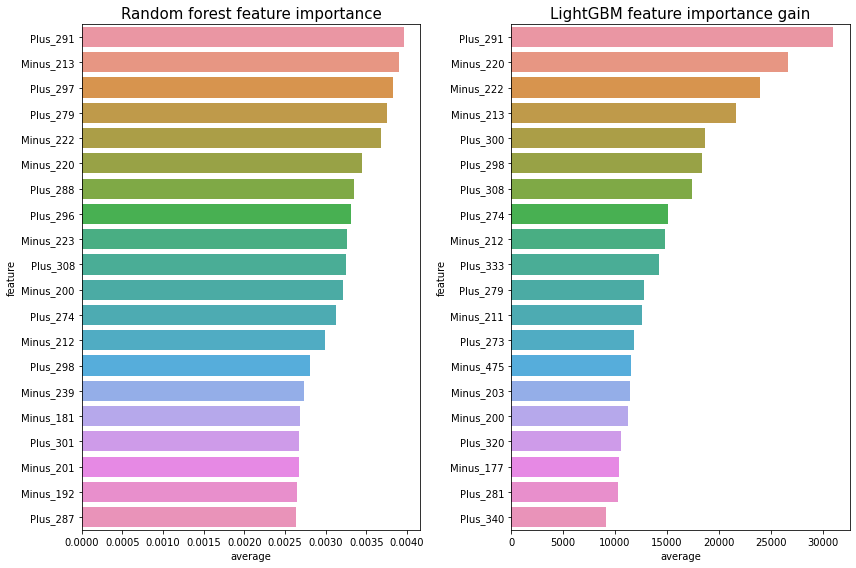

In [ ]:
# Feature importance
plt.figure(figsize=(12, 8))
gs = gridspec.GridSpec(1, 2)

ax = plt.subplot(gs[0, 0])
sns.barplot(x='average', y='feature', data=rf_importance.sort_values('average', ascending=False).iloc[0:20], ax=ax)
plt.title("Random forest feature importance", fontsize=15)

ax = plt.subplot(gs[0, 1])
sns.barplot(x='average', y='feature', data=lgb_importance.sort_values('average', ascending=False).iloc[0:20], ax=ax)
plt.title("LightGBM feature importance gain", fontsize=15)

# ax = plt.subplot(gs[0, 2])
# sns.barplot(x='lgb_importance_split', y='feature', data=imp_df.sort_values('lgb_importance_split', ascending=False).iloc[0:20], ax=ax)
# ax.set_title('LightGBM feature importance split', fontsize=15)
plt.tight_layout()
plt.savefig(f"{DIRECTORY}feature_importance_{FILENAME}.png", dpi = 300)
plt.show()

# Export files
rf_importance.to_csv(f"{DIRECTORY}rf_importance_{FILENAME}.csv", index=False)
lgb_importance.to_csv(f"{DIRECTORY}lgb_importance_{FILENAME}.csv", index=False)

In [ ]:
# # LGBM Feature importance
# plt.rcParams['figure.figsize'] = (18.0, 4)
# fig, ax = plt.subplots(figsize=(12,8))
# lgb.plot_importance(lgb_model, max_num_features=20, height=0.8, ax=ax)
# ax.grid(False)
# plt.title("LightGBM feature importance ", fontsize=15)

## Performance evaluation

In [ ]:
# Initialize the models to evaluate
train_output_lst = rf_train_output, rf_bal_train_output, rf_balsub_train_output, lgb_train_output   # rf_opt_train_outpu
val_output_lst = rf_val_output, rf_bal_val_output, rf_balsub_val_output, lgb_val_output           # rf_opt_val_output
names = "RF", "Blc RF", "Blc Sub RF", "LGBM"                                                                 # "Tuned RF"

#### Classification report

In [ ]:
# Classification report
for i in range(len(names)):
  print(f"{names[i]}:\n", classification_report(val_output_lst[i]["ytrue"], val_output_lst[i]["ypred"])) 

RF:
               precision    recall  f1-score   support

         0.0       0.63      0.54      0.58     24614
         1.0       0.79      0.84      0.81     50069

    accuracy                           0.74     74683
   macro avg       0.71      0.69      0.70     74683
weighted avg       0.74      0.74      0.74     74683

Blc RF:
               precision    recall  f1-score   support

         0.0       0.60      0.62      0.61     24614
         1.0       0.81      0.79      0.80     50069

    accuracy                           0.74     74683
   macro avg       0.70      0.71      0.71     74683
weighted avg       0.74      0.74      0.74     74683

Blc Sub RF:
               precision    recall  f1-score   support

         0.0       0.60      0.62      0.61     24614
         1.0       0.81      0.79      0.80     50069

    accuracy                           0.74     74683
   macro avg       0.70      0.71      0.71     74683
weighted avg       0.74      0.74      0.74    

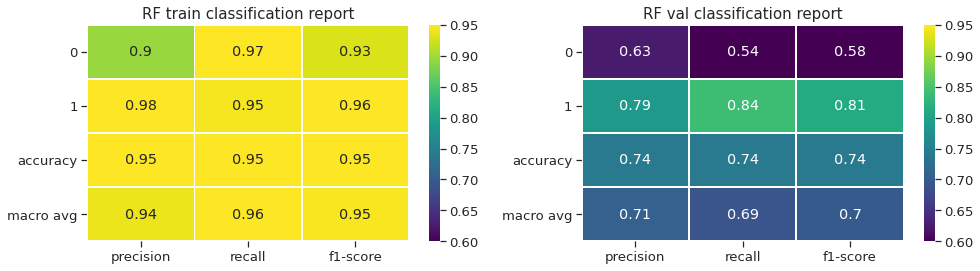

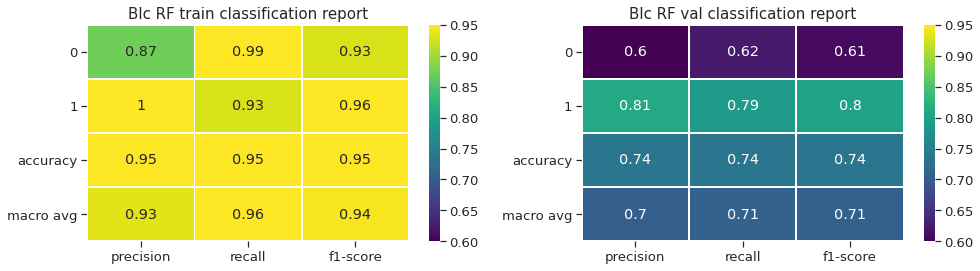

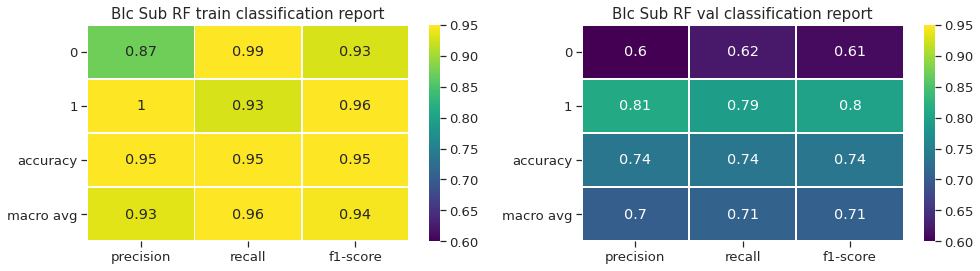

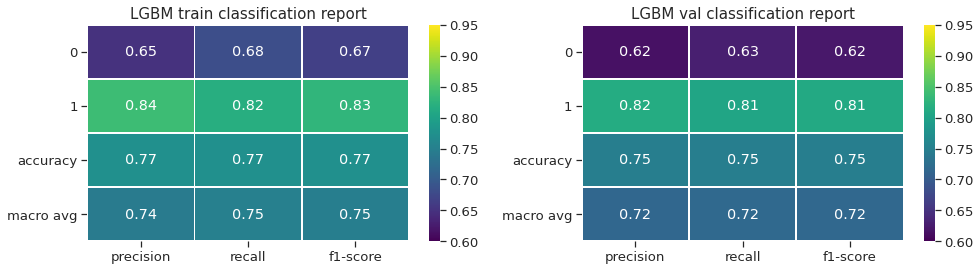

In [ ]:
# Plot classification report
def plot_clf_report(train_output, val_output, name="", save=False):
  plt.figure(figsize=(14, 4))
  gs = gridspec.GridSpec(1, 2)
  sns.set(font_scale=1.2, style="ticks")
  # Train
  ax = plt.subplot(gs[0, 0])
  clf_report = classification_report(train_output["ytrue"], train_output["ypred"],
                                    labels=[0,1], output_dict=True)
  sns.heatmap(pd.DataFrame(clf_report).iloc[:-1, :].drop(["weighted avg"], axis=1).T, 
              annot=True, linewidths=1, cmap="viridis", ax=ax, vmin=0.6, vmax=0.95)
  ax.set_title(f"{name} train classification report", fontsize=15)
  # Validation
  ax = plt.subplot(gs[0, 1])
  clf_report = classification_report(val_output["ytrue"], val_output["ypred"],
                                    labels=[0,1], output_dict=True)
  sns.heatmap(pd.DataFrame(clf_report).iloc[:-1, :].drop(["weighted avg"], axis=1).T, 
              annot=True, linewidths=1, cmap="viridis", ax=ax, vmin=0.6, vmax=0.95)
  ax.set_title(f"{name} val classification report", fontsize=15)
  # Layout and save
  plt.tight_layout()
  if save:
    plt.savefig(f"{DIRECTORY}classification_report_{FILENAME}.png", dpi = 300)
  plt.show()

for i in range(len(names)):
  plot_clf_report(train_output_lst[i], val_output_lst[i], names[i], save=True)

#### Plot some metrics

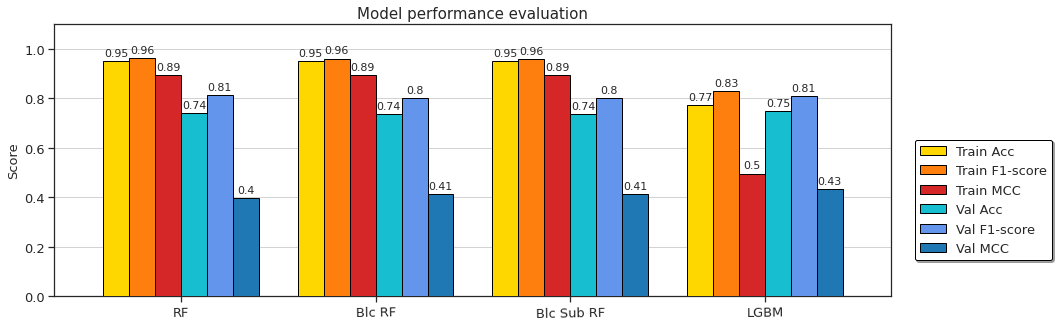

In [ ]:
# Plot accuracy, F1, MCC

def evaluate(ml_output):
  acc = get_accuracy(ml_output["ypred"], ml_output["ytrue"])
  f1 = f1_score(ml_output["ytrue"], ml_output["ypred"])
  mcc = matthews_corrcoef(ml_output["ytrue"], ml_output["ypred"])
  return acc, f1, mcc

def evaluate_lst(ml_output_lst):
  lst_acc, lst_f1, lst_mcc = [], [], []
  for ml_output in ml_output_lst: 
    acc, f1, mcc = evaluate(ml_output)
    lst_acc.append(acc)
    lst_f1.append(f1)
    lst_mcc.append(mcc)
  return lst_acc, lst_f1, lst_mcc

def plot_metrics(train_output_lst, val_output_lst, names, 
                 bbox_to_anchor=(1.03, 0.6), annotation_size=13, 
                 save=False):
  # Group by metrics
  train_acc, train_f1, train_mcc = evaluate_lst(train_output_lst)
  val_acc, val_f1, val_mcc = evaluate_lst(val_output_lst)
  # Plot
  metric_df = pd.DataFrame({"Train Acc": train_acc, "Train F1-score": train_f1, "Train MCC": train_mcc,
                            "Val Acc": val_acc, "Val F1-score": val_f1, "Val MCC": val_mcc, }, 
                            index = names)
  ax = metric_df.plot(y=["Train Acc", "Train F1-score", "Train MCC", "Val Acc", "Val F1-score", "Val MCC"], 
                      ylim=(0,1.1), figsize=(15,5), fontsize=13, kind="bar", zorder=3, ec ="black",
                      rot=1, width=0.8, color = ["gold", "tab:orange", "tab:red",
                                                "tab:cyan", "cornflowerblue", "tab:blue"])
  # Add details
  plt.title("Model performance evaluation", fontsize = 15)
  plt.ylabel("Score", fontsize = 13)
  plt.grid(axis="y", zorder=0, color="lightgray")  
  legend = plt.legend(frameon = 1, shadow = True, bbox_to_anchor=bbox_to_anchor, fontsize=13)
  frame = legend.get_frame()
  frame.set_facecolor('white')
  frame.set_edgecolor('black')
  # Annotate scores on top of the bars
  for p in ax.patches:
    height = p.get_height()
    ha = {'center': 'center', 'right': 'left', 'left': 'right'}
    xpos='center'
    offset = {'center': 0, 'right': 1, 'left': -1}
    ax.annotate(f"{height:.2}",
                xy=(p.get_x() + p.get_width() / 2, height),
                xytext=(offset[xpos]*3, 3),  
                textcoords="offset points",  
                ha=ha[xpos], va='bottom', size=annotation_size)
  if save:
    plt.savefig(f"{DIRECTORY}models_performance_{FILENAME}.png", 
                dpi = 300, bbox_extra_artists=(legend,), bbox_inches='tight')
  plt.show()

plot_metrics(train_output_lst, val_output_lst, names, 
             bbox_to_anchor=(1.2, 0.6), annotation_size=11)                        # annotation_size= 13 for 2, 12 for 3, 11 for 4

#### ROC

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:22: RuntimeWarning: divide by zero encountered in log10
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:22: RuntimeWarning: divide by zero encountered in log10
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:22: RuntimeWarning: divide by zero encountered in log10
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:22: RuntimeWarning: divide by zero encountered in log10


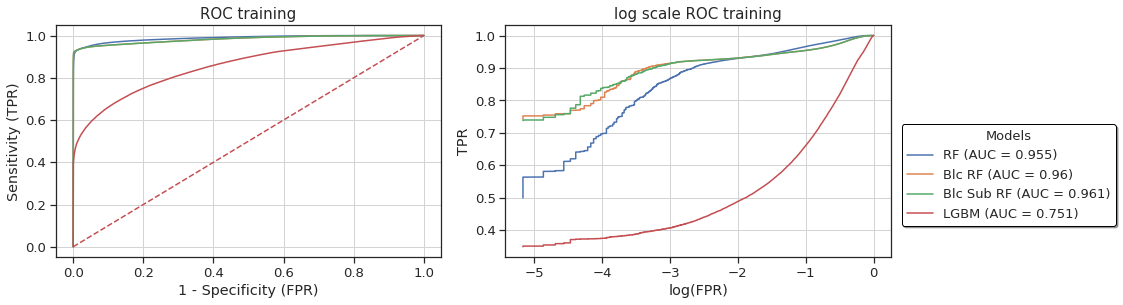

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:22: RuntimeWarning: divide by zero encountered in log10
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:22: RuntimeWarning: divide by zero encountered in log10
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:22: RuntimeWarning: divide by zero encountered in log10
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:22: RuntimeWarning: divide by zero encountered in log10


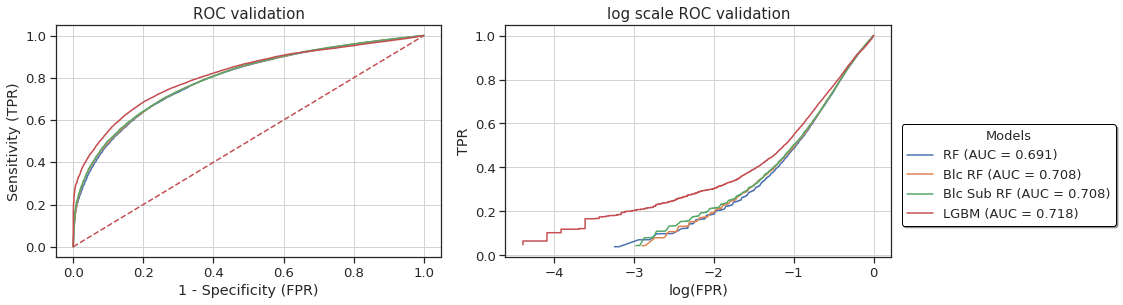

In [ ]:
# Compute AUC, FPR and TPR
def get_auc_fpr_tpr(ml_output):
  auc = roc_auc_score(ml_output["ytrue"], ml_output["ypred"])
  fpr, tpr, _ = roc_curve(ml_output["ytrue"], ml_output["yprob"])
  return auc, fpr, tpr

# Plot ROC
def plot_ROC(output_lst, names, plot_name="", save=False):
  fig, axes = plt.subplots(1, 2, figsize = (16, 4.5))
  # ROC
  for i, output in enumerate(output_lst):
    auc, fpr, tpr = get_auc_fpr_tpr(output)
    axes[0].plot(fpr, tpr, label=f"{names[i]} (AUC = {auc:.3})", zorder=3)
  axes[0].plot([0, 1], [0, 1],'r--')
  axes[0].set_title(f"ROC {plot_name}", fontsize=15)
  axes[0].set_xlabel('1 - Specificity (FPR)')
  axes[0].set_ylabel('Sensitivity (TPR)')
  axes[0].grid(zorder=0, color="lightgray")
  # Log ROC
  for i, output in enumerate(output_lst):
    auc, fpr, tpr = get_auc_fpr_tpr(output)
    axes[1].plot(np.log10(fpr), tpr, label=f"{names[i]} (AUC = {auc:.3})", zorder=3)
  axes[1].set_title(f"log scale ROC {plot_name}", fontsize=15)
  axes[1].set_xlabel('log(FPR)')
  axes[1].set_ylabel('TPR')
  axes[1].grid(zorder=0, color="lightgray")
  # Details
  legend = plt.legend(title="Models", fontsize=13, title_fontsize=13,
                      frameon = 1, shadow = True, bbox_to_anchor=(1.6, 0.6))
  frame = legend.get_frame()
  frame.set_facecolor('white')
  frame.set_edgecolor('black')
  fig.tight_layout()
  fig.subplots_adjust(top=0.89)
  if save:
    plt.savefig(f"{DIRECTORY}ROC_logROC_{plot_name}_{FILENAME}.png", dpi = 300)
  plt.show()

plot_ROC(train_output_lst, names, plot_name="training", save=True)
plot_ROC(val_output_lst, names, plot_name="validation", save=True)

#### Precision recall curve

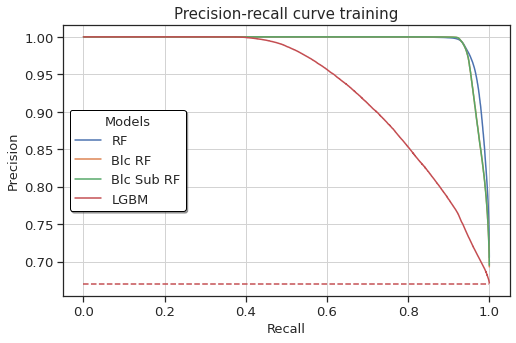

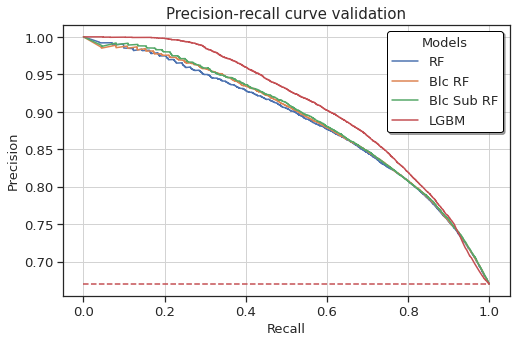

In [ ]:
# Precision-recall curve
def plot_precision_recall_curve(output_lst, names, plot_name="", save=False):
  # Plot the curves
  plt.figure(figsize=(8, 5))
  random_clf = len(output_lst[0]["ytrue"][output_lst[0]["ytrue"]==1]) / len(output_lst[0]["ytrue"])
  plt.plot([0, 1], [random_clf, random_clf], 'r--', zorder=3)
  for i, val_output in enumerate(output_lst):
    precision, recall, thresholds = precision_recall_curve(val_output["ytrue"], val_output["yprob"])
    plt.plot(recall, precision, label=names[i], zorder=3)
  # Add details
  plt.grid(zorder=0, color="lightgray")
  plt.xlabel("Recall", fontsize=13)
  plt.ylabel("Precision", fontsize=13)
  plt.title(f"Precision-recall curve {plot_name}", fontsize=15)
  legend = plt.legend(title="Models", fontsize=13, title_fontsize=13,
            frameon = 1, shadow = True)
  frame = legend.get_frame()
  frame.set_facecolor("white")
  frame.set_edgecolor("black")
  if save:
    plt.savefig(f"{DIRECTORY}precision-recall_curve_{plot_name}_{FILENAME}.png", dpi = 300)
  plt.show()

plot_precision_recall_curve(train_output_lst, names, plot_name="training", save=True)
plot_precision_recall_curve(val_output_lst, names, plot_name="validation", save=True)

#### Confusion matrix

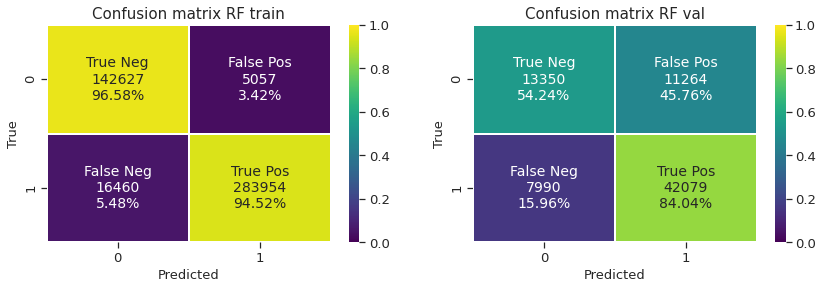

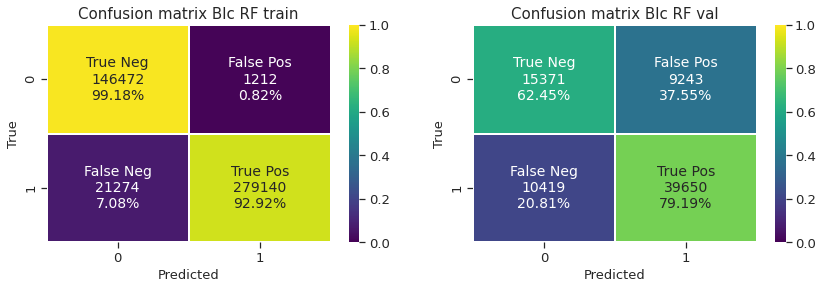

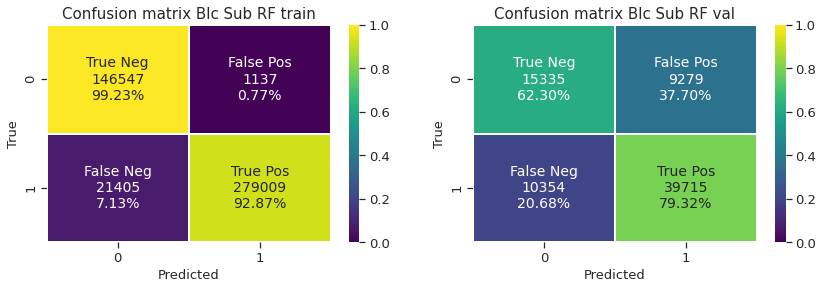

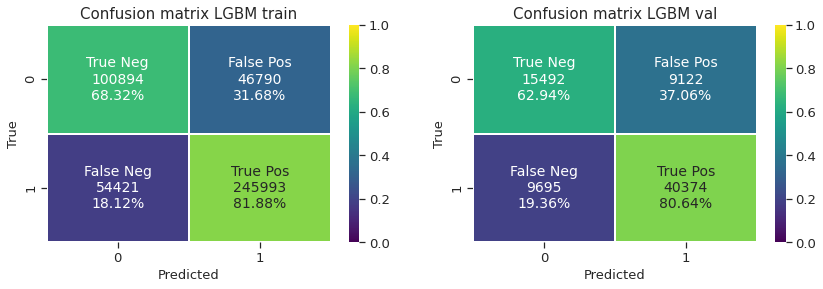

In [ ]:
# Plot confusion matrix
def plot_confusion_matrix(train_output, val_output, name="",
                          vmax=0.6, save=False, filename="", cmap='viridis'):
  # Initialize
  val_train_output = train_output, val_output
  plot_names = "train", "val"
  plt.figure(figsize=(14, 4))
  gs = gridspec.GridSpec(1, 2)
  sns.set(font_scale=1.2, style="ticks")
  # Plot train and validation 
  for i, output in enumerate(val_train_output):
    ax = plt.subplot(gs[0, i])
    # Get confusion matrix and labels
    cf_matrix = confusion_matrix(output["ytrue"], output["ypred"])
    group_names = ["True Neg","False Pos","False Neg","True Pos"]
    group_counts = [f"{value}" for value in cf_matrix.flatten()]
    row_sums = cf_matrix.sum(axis=1)
    norm_matrix = cf_matrix / row_sums[:, np.newaxis]
    group_percentages = [f"{value*100:.2f}%" for value in norm_matrix.flatten()]
    labels = [f"{v1}\n{v2}\n{v3}" for v1, v2, v3 in
              zip(group_names, group_counts, group_percentages)]
    labels = np.asarray(labels).reshape(2,2)
    # Plot heatmap
    sns.heatmap(norm_matrix, annot=labels, annot_kws={"size": 14}, 
                fmt="", vmin=0, vmax=1, cmap=cmap, linewidths=1, ax=ax)
    plt.ylabel("True", fontsize = 13)
    plt.xlabel("Predicted", fontsize = 13)
    plt.title(f"Confusion matrix {name} {plot_names[i]}", fontsize = 15)
  if save:
    plt.savefig(f"{DIRECTORY}confusion_matrix_{name}_{FILENAME}.png", 
                dpi = 300)
  plt.show()

for i in range(len(names)):
  plot_confusion_matrix(train_output_lst[i], val_output_lst[i], names[i], save=True)